# Import packages and libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import gensim
import re
from collections import Counter, defaultdict
from wordcloud import WordCloud, STOPWORDS
RANDOM_SEED = 1

# Combine all the csv files and remove account identifiers

In [2]:
tweets = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        df = pd.read_csv(os.path.join(dirname, filename), index_col=None, header=0)
        df = df[(df['lang']=='en') & (df['country_code'] == 'US')]
        row, cols = df.shape
        date = [filename[0:10]]*row
        df['date_of_tweet'] = date
        tweets.append(df)
        
tweets_en_US = pd.concat(tweets, axis=0, ignore_index=True)
del tweets

# random samples of tweets 
print(tweets_en_US.text.sample(5))

# print columns of dataframe
# print(tweets_en_US.columns)

#drop columns with user sensitive information 
finalTweets =tweets_en_US.copy()
finalTweets.drop(['status_id','user_id','screen_name','source','reply_to_status_id',
                                    'reply_to_user_id','is_retweet','place_full_name','place_type',
                                    'reply_to_screen_name','is_quote','followers_count','friends_count',
                                    'account_lang','account_created_at','verified'],axis=1, inplace = True)
print(finalTweets.columns)
print(finalTweets.shape)

/kaggle/input/coronavirus-covid19-tweets-late-april/2020-04-20 Coronavirus Tweets.CSV
/kaggle/input/coronavirus-covid19-tweets-late-april/2020-04-17 Coronavirus Tweets.CSV
/kaggle/input/coronavirus-covid19-tweets-late-april/2020-04-25 Coronavirus Tweets.CSV
/kaggle/input/coronavirus-covid19-tweets-late-april/2020-04-19 Coronavirus Tweets.CSV
/kaggle/input/coronavirus-covid19-tweets-late-april/2020-04-21 Coronavirus Tweets.CSV
/kaggle/input/coronavirus-covid19-tweets-late-april/2020-04-30 Coronavirus Tweets.CSV
/kaggle/input/coronavirus-covid19-tweets-late-april/2020-04-23 Coronavirus Tweets.CSV
/kaggle/input/coronavirus-covid19-tweets-late-april/2020-04-16 Coronavirus Tweets.CSV
/kaggle/input/coronavirus-covid19-tweets-late-april/2020-04-28 Coronavirus Tweets.CSV
/kaggle/input/coronavirus-covid19-tweets-late-april/2020-04-18 Coronavirus Tweets.CSV
/kaggle/input/coronavirus-covid19-tweets-late-april/2020-04-22 Coronavirus Tweets.CSV
/kaggle/input/coronavirus-covid19-tweets-late-april/20

# Preprocessing Tweets 

Remove Stopwords, Punctuations, Emoticons, URLS

Maintain Hashtags and Mentions (as they'll be used those later)

In [3]:
#Extra stopwords to eliminate common hashtags

stop_words.add('#covid19')
stop_words.add('#covid19?')
stop_words.add('#covid19!')
stop_words.add('#covid19,')
stop_words.add('#covid19.')
stop_words.add('#covid_19')
stop_words.add('#coronavirus')
stop_words.add('#coronavirus.')
stop_words.add('#coronavirusupdate')
stop_words.add('#coronaviru')
stop_words.add('#covid_19.')
stop_words.add('#covid19pandemic')
stop_words.add('#coronaviruspandemic')
stop_words.add('#coronavirususa')
stop_words.add('#covid2019')
stop_words.add('#coronavirusupdates')
stop_words.add('#coronavirusnyc')
stop_words.add('#coronavirus...')
stop_words.add('#covid19...')
stop_words.add('#covid19us')
stop_words.add('#coronavirus?')
stop_words.add('#sarscov2')
stop_words.add('#covīd19')
stop_words.add('#covid 19 ')



In [4]:
import string
punct = string.punctuation

import emoji

def deEmojify(text):
    allchars = [str for str in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text.split() 
                           if not any(i in str for i in emoji_list)])
    return clean_text

def removeURL(text):
    clean_text = re.sub(r"http\S+", "", text)
    return clean_text

def tokenizeTweets(dataframe):
    tokenized_data = []
    for i,tweet in enumerate(dataframe['text']):
        sentence = []
        tweet = deEmojify(tweet)
        tweet = removeURL(tweet)
        for w in tweet.split():
            if w.lower() not in stop_words and w not in punct and w!='&amp;':
                sentence.append(w.lower())
        dataframe['text'][i] = ' '.join(sentence)
        tokenized_data.append(sentence)       
    return tokenized_data, dataframe

tokenizedTweets, finalTweets = tokenizeTweets(finalTweets)
print(finalTweets['text'][:5])
print(tokenizedTweets[:5])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0    it’s fascinating witness natural selection rea...
1    cat. loves outdoors. wine mom. #sunbathingcat ...
2    last week’s demolition @hilcoglobal’s coal pla...
3    @weijia he’s showing draconian test position k...
4    #trumpmeltdown holy shit. put "captain bligh" ...
Name: text, dtype: object
[['it’s', 'fascinating', 'witness', 'natural', 'selection', 'real', 'time.', '#stayathome', '#darwin'], ['cat.', 'loves', 'outdoors.', 'wine', 'mom.', '#sunbathingcat', '#decklife', '#sunnydays', '#stayhome', '#sanfrancisco', '#nobhillsf', 'nob', 'hill,', 'san', 'francisco'], ['last', 'week’s', 'demolition', '@hilcoglobal’s', 'coal', 'plant', 'lv', 'devastating', 'consequences.', 'wife', 'hearing', 'fellow', 'residents', 'experiencing', 'chest', 'tightness', 'lung', 'irritation.', 'struggle', 'together', 'environmental', 'racism', 'pervasive?'], ['@weijia', 'he’s', 'showing', 'draconian', 'test', 'position', 'kushner’s', 'less', 'invasive', 'alternative.', 'trump', 'making', 'money'], ['#tr

In [5]:
from PIL import Image
def show_WordCloud(data_list, title = None):
    data_list_compiled = ''
    data_list_compiled += " ".join(data_list)+" "
    wordcloud = WordCloud(background_color = 'white', max_words = 200, min_font_size = 8, max_font_size=40).generate(str(data_list_compiled))
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()
    
def top_list_elements(list_data, N = 20):
    #returns a dictionary of hashtags and the number of times they have been used
    
    count =Counter(list_data)
    top_elements = dict(sorted(count.items(), key = lambda x:x[1], reverse = True)[:N])
    return top_elements

# Top Hashtags used

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


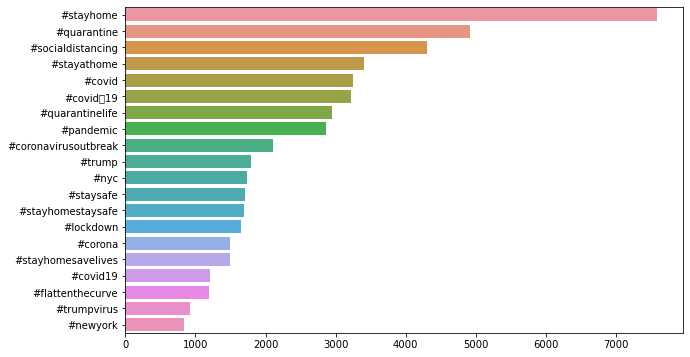

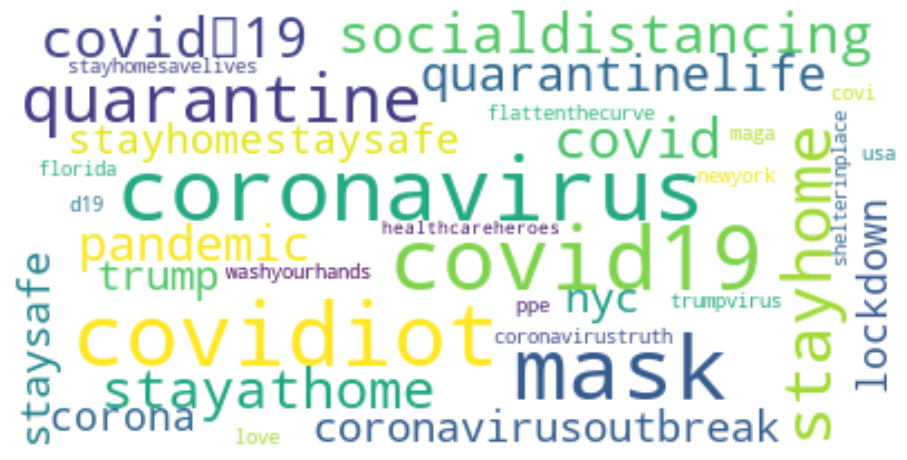

In [6]:
def extract_Hashtags(tokenized_data):
    # returns list of hashtags used
    list_hashtag = []
    for tweets in tokenized_data:
        list_hashtag.append([w for w in tweets if w.startswith('#')])
    return [item for sublist in list_hashtag for item in sublist]

tweets_Hashtag = extract_Hashtags(tokenizedTweets)
top_N_Hashtags = top_list_elements(tweets_Hashtag, N=100)

plt.figure(figsize = (10, 6))
sns.barplot(x = list(top_N_Hashtags.values())[:20], y = list(top_N_Hashtags.keys())[:20])
plt.show()

plt.figure(figsize = (16, 16))
show_WordCloud(list(top_N_Hashtags.keys()))



# Top Mentions

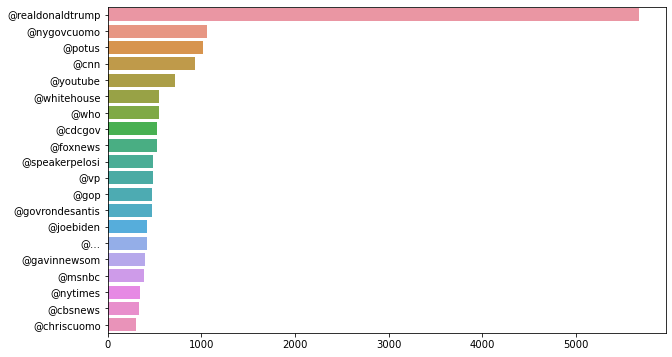

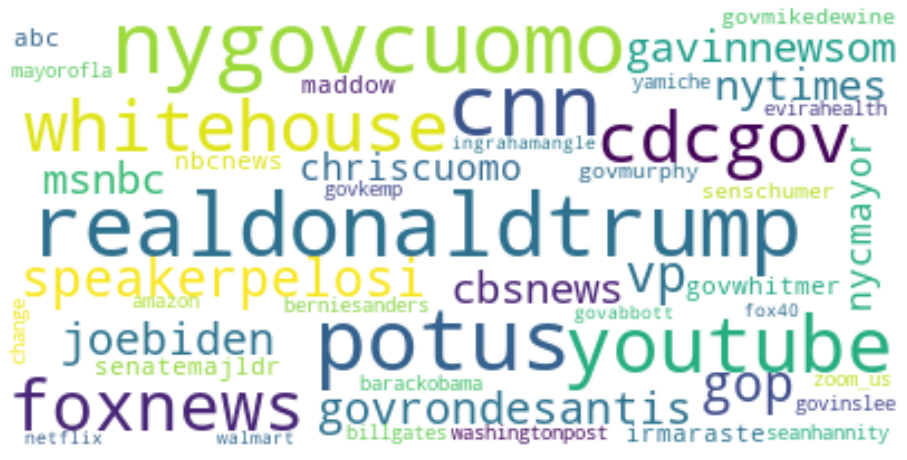

In [7]:
def extract_Mentions(tokenized_data):
    # returns list of mentions used 
    list_mentions = []
    for tweets in tokenized_data:
        list_mentions.append([w for w in tweets if w.startswith('@')])
    return [item for sublist in list_mentions for item in sublist]

tweets_mentions = extract_Mentions(tokenizedTweets)
top_N_Mentions = top_list_elements(tweets_mentions, N=50)

plt.figure(figsize = (10, 6))
sns.barplot(x = list(top_N_Mentions.values())[:20], y = list(top_N_Mentions.keys())[:20])
plt.show()

plt.figure(figsize = (16, 16))
show_WordCloud(list(top_N_Mentions.keys()))


# Extracting the sentiments of these tweets

In [8]:
from textblob import TextBlob

import warnings
warnings.filterwarnings("ignore")

finalTweets['sentiment'] = ' '
finalTweets['polarity'] = None
for i,tweets in enumerate(finalTweets.text) :
    blob = TextBlob(tweets)
    finalTweets['polarity'][i] = blob.sentiment.polarity
    if blob.sentiment.polarity > 0 :
        finalTweets['sentiment'][i] = 'positive'
    elif blob.sentiment.polarity < 0 :
        finalTweets['sentiment'][i] = 'negative'
    else :
        finalTweets['sentiment'][i] = 'neutral'
finalTweets.head()

,created_at,text,favourites_count,retweet_count,country_code,lang,date_of_tweet,sentiment,polarity
0,2020-04-20T00:00:14Z,it’s fascinating witness natural selection rea...,26909,1,US,en,2020-04-20,positive,0.333333
1,2020-04-20T00:00:42Z,cat. loves outdoors. wine mom. #sunbathingcat ...,830,0,US,en,2020-04-20,neutral,0
2,2020-04-20T00:01:03Z,last week’s demolition @hilcoglobal’s coal pla...,1230,0,US,en,2020-04-20,negative,-0.5
3,2020-04-20T00:01:18Z,@weijia he’s showing draconian test position k...,793,0,US,en,2020-04-20,negative,-0.166667
4,2020-04-20T00:01:23Z,"#trumpmeltdown holy shit. put ""captain bligh"" ...",22934,0,US,en,2020-04-20,negative,-0.6


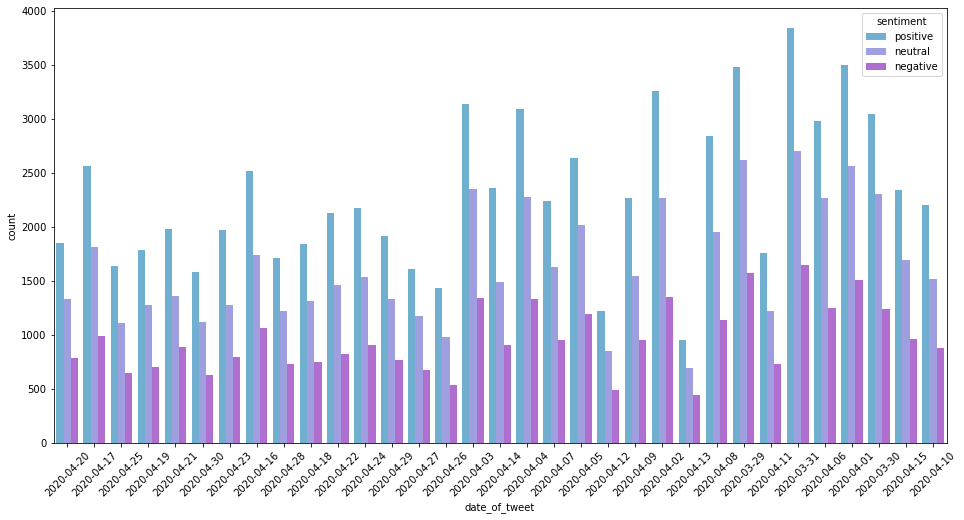

In [9]:
plt.figure(figsize = (16,8))
sns.countplot(x = finalTweets['date_of_tweet'], hue = 'sentiment', 
              data = finalTweets, palette = 'cool', saturation = 0.5)
plt.xticks(Rotation = 45)
plt.show()

*The sentiment of tweeets is positive every day in the given period. However, towards mid April tweeter users were much less active and percentage of positive tweets diminished as well.*

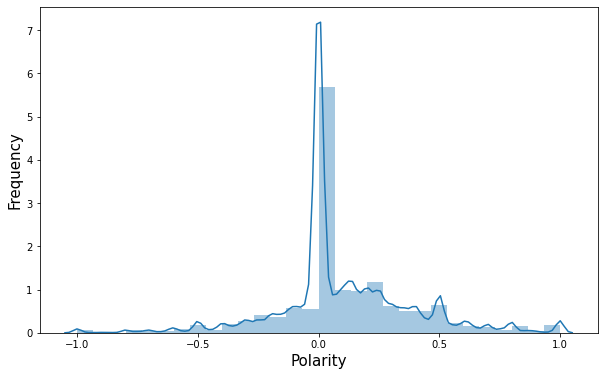

In [10]:
plt.figure(figsize = (10, 6))
sns.distplot(finalTweets['polarity'], bins = 30)
plt.xlabel('Polarity',size = 15)
plt.ylabel('Frequency',size = 15)
plt.show()

*We can see a fatter tail of the polarity in the positive direction.* 

In [11]:
pos = finalTweets['text'][finalTweets['sentiment'] == 'positive']
neutral = finalTweets['text'][finalTweets['sentiment'] == 'neutral']
neg = finalTweets['text'][finalTweets['sentiment'] == 'negative']

def extract_list(dataframe):
    data = []
    for tweet in dataframe:
        data.append(tweet.split())
    return data

pos_list = extract_list(pos)
neu_list = extract_list(neutral)
neg_list = extract_list(neg)

# The top hashtags in tweets of different sentiments

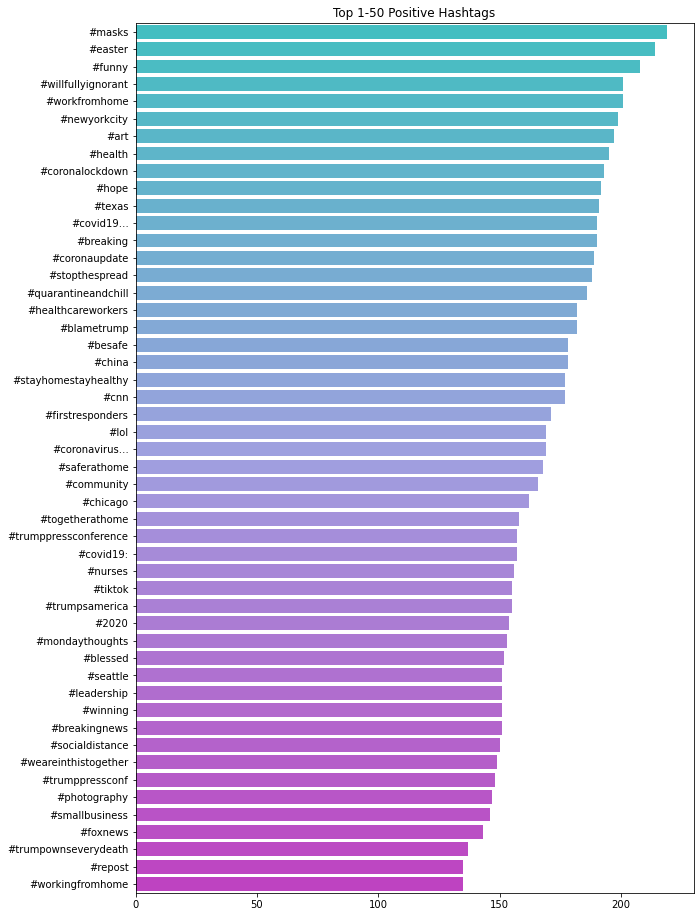

In [12]:
# Check the Hashtags in tweets of different sentiments

pos_Hashtag = extract_Hashtags(pos_list)
top_N_pos_Hashtags = top_list_elements(pos_Hashtag, N=100)
plt.figure(figsize = (10,16))
sns.barplot(x = list(top_N_pos_Hashtags.values())[50:], y = list(top_N_pos_Hashtags.keys())[50:], 
            palette = 'cool', saturation = 0.5)
plt.title('Top 1-50 Positive Hashtags')
plt.show()

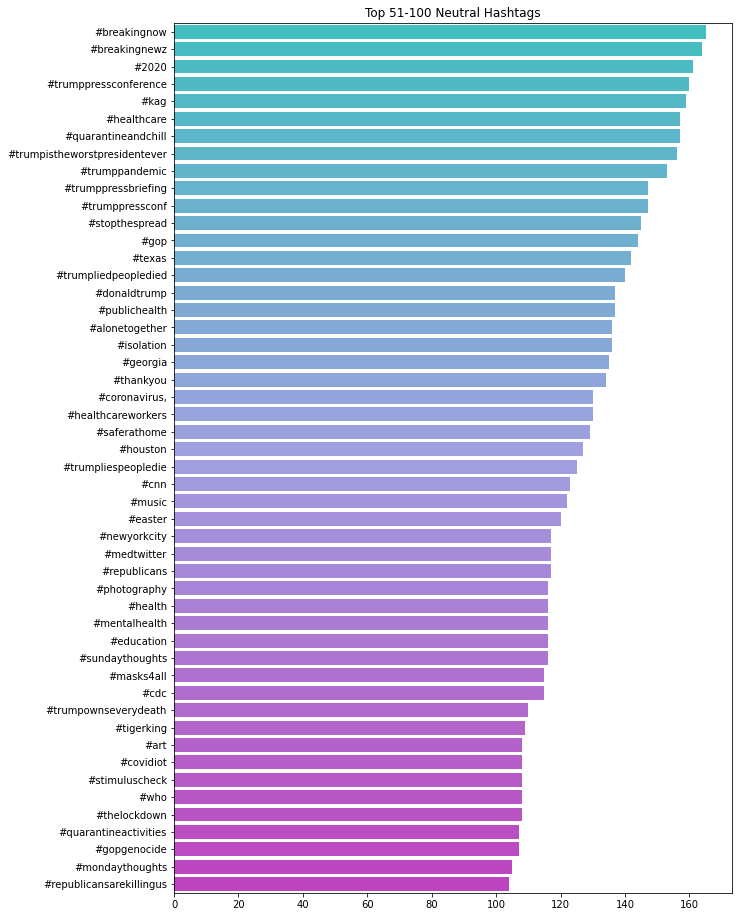

In [13]:
neu_Hashtag = extract_Hashtags(neu_list)
top_N_neu_Hashtags = top_list_elements(neu_Hashtag, N=100)
plt.figure(figsize = (10,16))
sns.barplot(x = list(top_N_neu_Hashtags.values())[50:], y = list(top_N_neu_Hashtags.keys())[50:], 
            palette = 'cool', saturation = 0.5)
plt.title('Top 51-100 Neutral Hashtags')
plt.show()

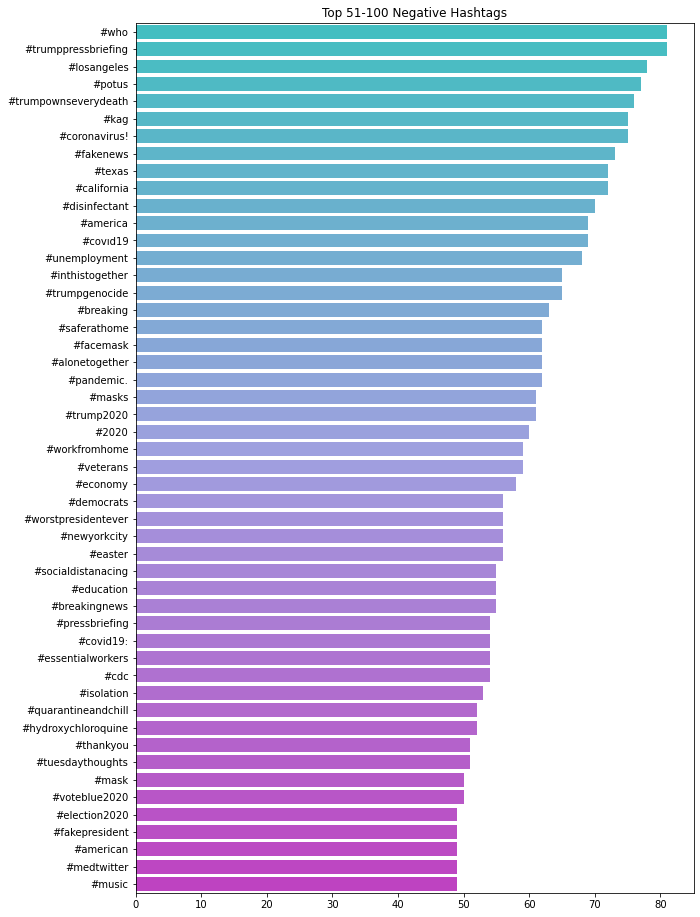

In [14]:
neg_Hashtag = extract_Hashtags(neg_list)
top_N_neg_Hashtags = top_list_elements(neg_Hashtag, N=100)
plt.figure(figsize = (10,16))
sns.barplot(x = list(top_N_neg_Hashtags.values())[50:], y = list(top_N_neg_Hashtags.keys())[50:], 
            palette = 'cool', saturation = 0.5)
plt.title('Top 51-100 Negative Hashtags')
plt.show()

*Differences in hashtags used are apparent only if we skip the top 50 hashtags.*

# The top mentions in tweets of different sentiments

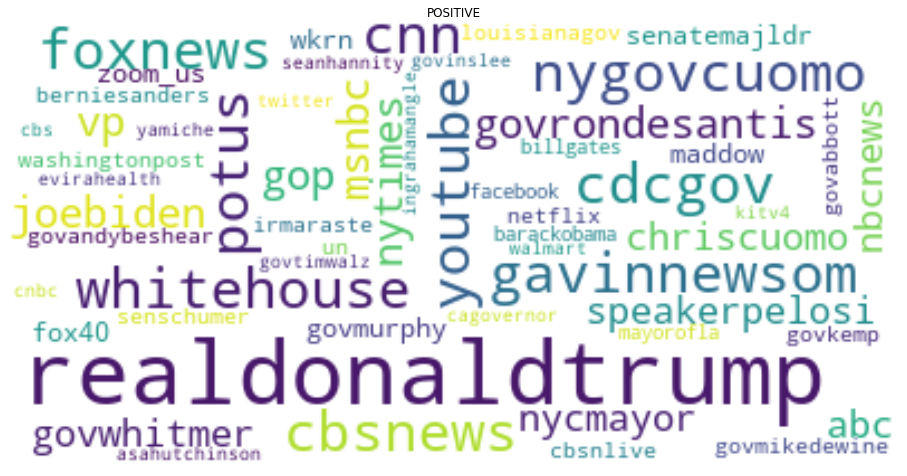

In [15]:
# Check the mentions in tweets of different sentiments
pos_mention = extract_Mentions(pos_list)
top_N_pos_Mentions = top_list_elements(pos_mention, N=200)
plt.figure(figsize = (16,10))
show_WordCloud(top_N_pos_Mentions , 'POSITIVE')

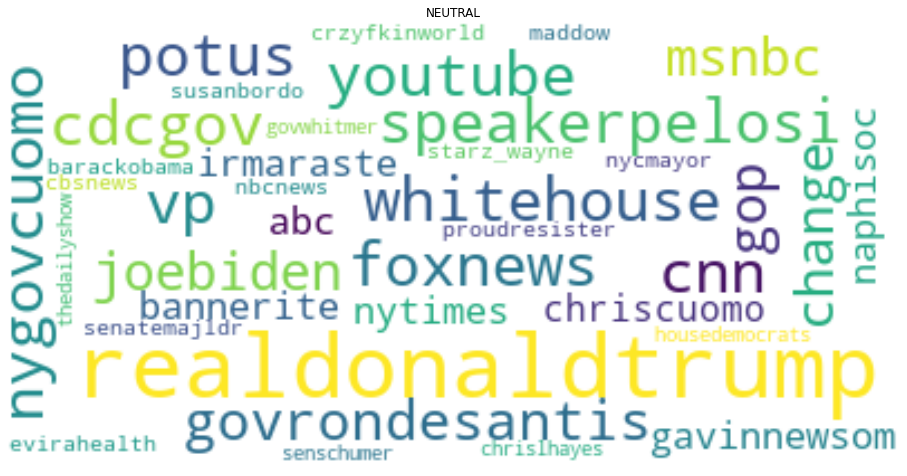

In [16]:
neu_mention = extract_Mentions(neu_list)
top_N_neu_Mentions = top_list_elements(neu_mention, N=200)
plt.figure(figsize = (16,10))
show_WordCloud(top_N_neu_Mentions , 'NEUTRAL')

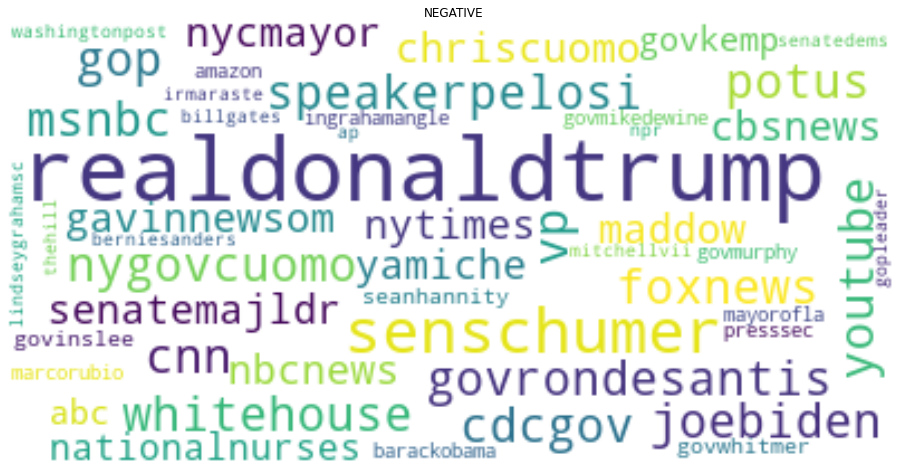

In [17]:
neg_mention = extract_Mentions(neg_list)
top_N_neg_Mentions = top_list_elements(neg_mention, N=200)
plt.figure(figsize = (16,10))
show_WordCloud(top_N_neg_Mentions , 'NEGATIVE')

# The words used in tweets of different sentiments

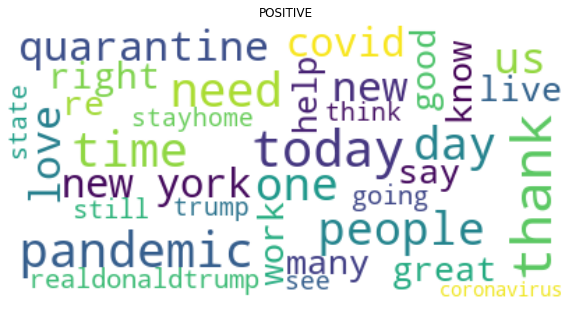

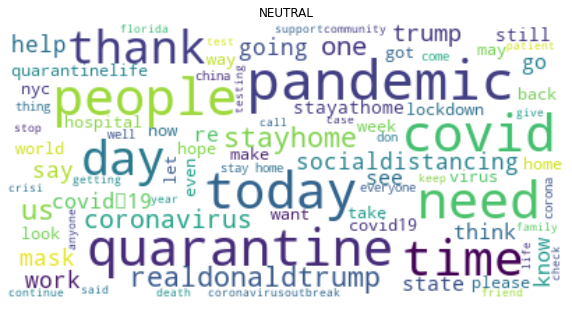

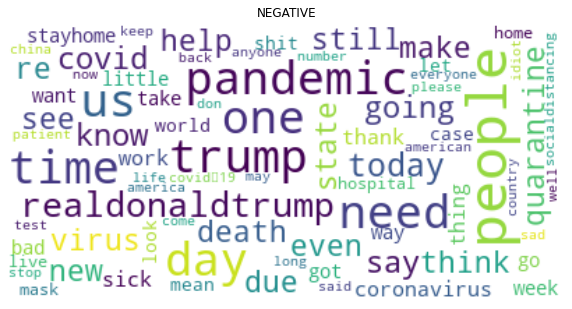

In [18]:
plt.figure(figsize = (10,10))
show_WordCloud(pos , 'POSITIVE')

plt.figure(figsize = (10,10))
show_WordCloud(neutral , 'NEUTRAL')

plt.figure(figsize = (10,10))
show_WordCloud(neg , 'NEGATIVE')

# Visualize similarity through t-SNE

Train a Word2Vec model using the given corpus

In [19]:
from gensim.models import Word2Vec

def train_w2v(tokenized_corpus):
    w2v_model = Word2Vec(min_count = 20, sample = 0.05, negative = 10)
    w2v_model.build_vocab(tokenized_corpus)
    w2v_model.train(tokenized_corpus, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
    print('Trained....')
    return w2v_model

w2v_model = train_w2v(tokenizedTweets)


Trained....


Perform t-SNE and visualize

In [20]:
from sklearn.manifold import TSNE
def tsne_plot(model, word_list):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in word_list:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.axis('off')
    plt.show()

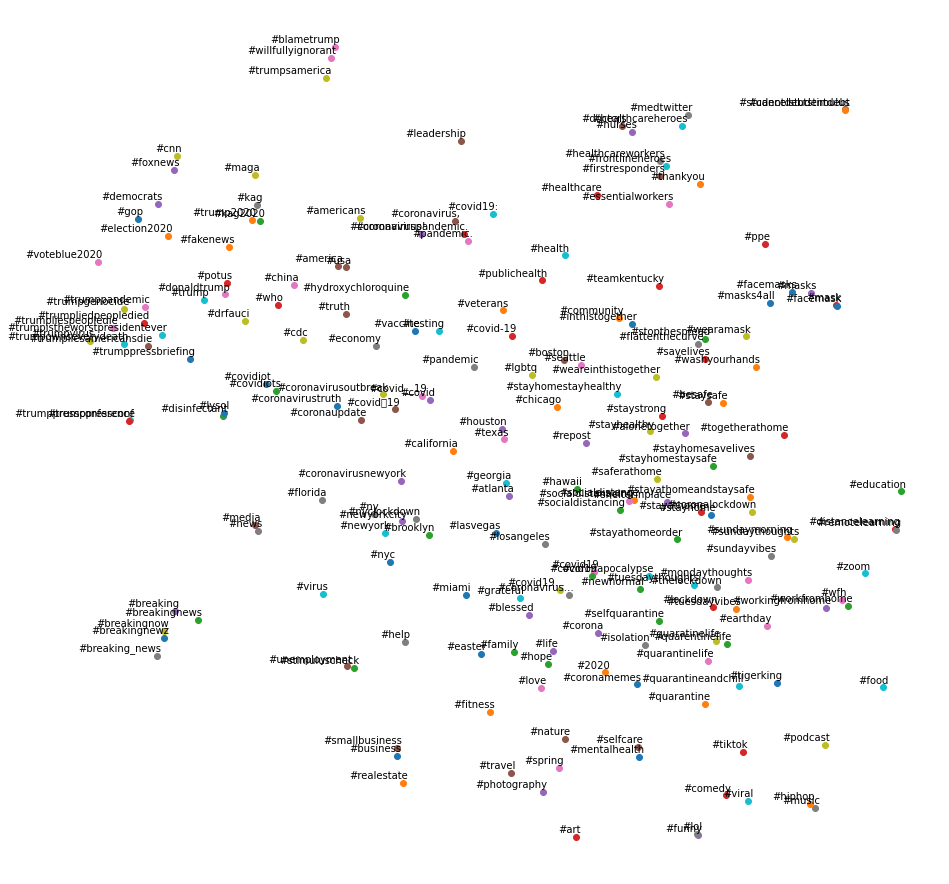

In [21]:
top_N_Hashtags = top_list_elements(extract_Hashtags(tokenizedTweets), N=200)
tsne_plot(w2v_model, list(top_N_Hashtags.keys()))

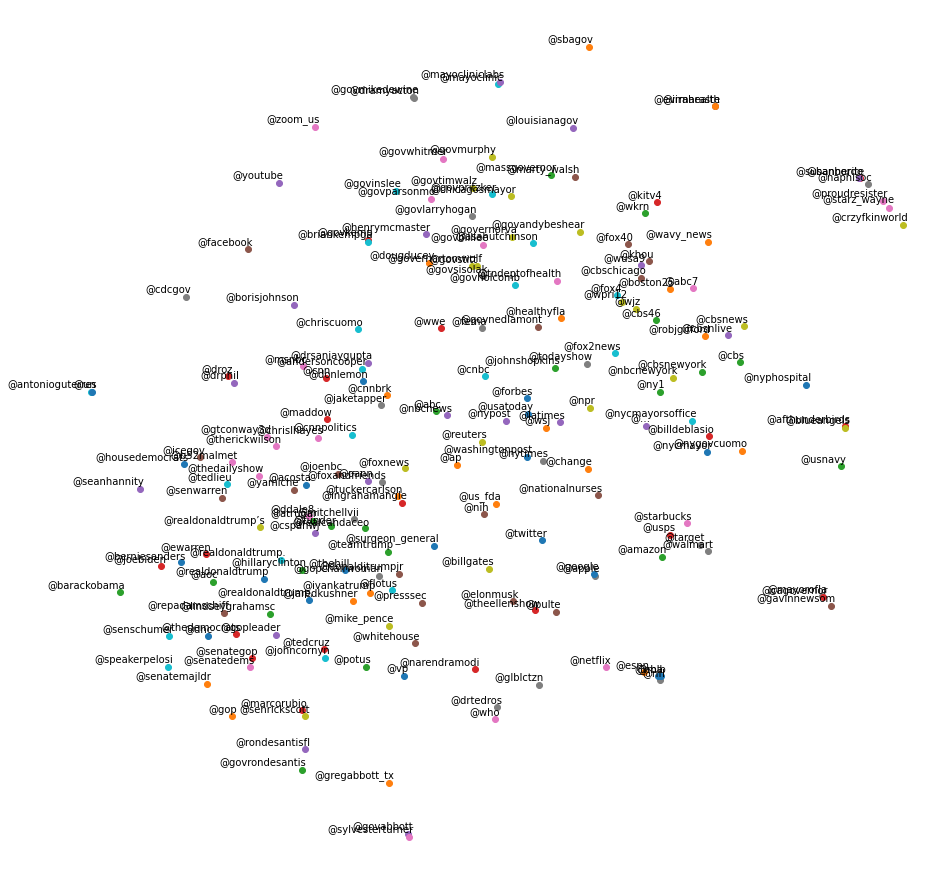

In [22]:
top_N_Mentions = top_list_elements(extract_Mentions(tokenizedTweets), N=200)
tsne_plot(w2v_model, list(top_N_Mentions.keys()))